In [ ]:
import numpy as np
import cv2
import pandas as pd
from tqdm.notebook import tqdm 
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras import layers
from tensorflow.keras.applications import DenseNet121
from tensorflow.keras.callbacks import Callback, ModelCheckpoint
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
import os
import random
import torch

In [ ]:
# configs
MODELS_FOLDER = '/content/drive/My Drive/df/models'
BASE_FOLDER = '/content/drive/My Drive/df'
TRAIN_SAMPLE_VIDEOS = 'train_sample_videos'
TRAIN_INPUT = 'input'
TEST_VIDEOS = 'test_videos'
TRAIN_FRAMES_FOLDER = 'train_frames'
VALID_FRAMES_FOLDER = 'valid_frames'
TEST_FRAMES_FOLDER = 'test_frames'
DATA_FOLDER = 'data'
TRAIN_FOLDER = 'train'
VALID_FOLDER = 'valid'
TEST_FOLDER = 'test'
TRAIN_FACE = 'train_face'
VALID_FACE = 'valid_face'
METADATA = 'metadata'
INPUT_SHAPE = (224, 224) 
BATCH_SIZE = 32

SEED = 1
random.seed(SEED)
torch.manual_seed(SEED)

In [ ]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator


train_datagen = ImageDataGenerator(rescale=1./255,
                                   rotation_range=20,
                                   zoom_range=0.15,
                                   width_shift_range=0.2,
                                   height_shift_range=0.2,
                                   shear_range=0.15,
                                   horizontal_flip=True,
                                   fill_mode="nearest")
valid_datagen = ImageDataGenerator(rescale=1./255)

train_dir = os.path.join(BASE_FOLDER, DATA_FOLDER, TRAIN_FACE)
valid_dir = os.path.join(BASE_FOLDER, DATA_FOLDER, VALID_FACE)

train_gen = train_datagen.flow_from_directory(
    train_dir,
    target_size=INPUT_SHAPE,
    batch_size=BATCH_SIZE,
    classes=['REAL', 'FAKE'],
    class_mode='binary',
    seed= SEED)

val_gen = valid_datagen.flow_from_directory(
    valid_dir,
    target_size=INPUT_SHAPE,
    batch_size=BATCH_SIZE,
    classes=['REAL', 'FAKE'],
    class_mode='binary',
    seed= SEED)

Found 12000 images belonging to 2 classes.
Found 6996 images belonging to 2 classes.


In [ ]:
densenet = DenseNet121(
    weights='/content/drive/My Drive/df/DenseNet-BC-121-32-no-top.h5',
    include_top=False,
    input_shape=(224,224,3)
)

for layer in densenet.layers:
    layer.trainable = False

In [ ]:
def build_model(densenet):
    model = Sequential()
    model.add(densenet)
    model.add(layers.GlobalAveragePooling2D())
    model.add(layers.BatchNormalization())
    model.add(layers.Dropout(0.5))
    
    model.add(layers.Dense(256, activation='relu'))
    model.add(layers.BatchNormalization())
    model.add(layers.Dropout(0.5))
    
    model.add(layers.Dense(1, activation='sigmoid'))
    
    model.compile(
        loss='binary_crossentropy',
        optimizer=Adam(lr=0.0005),
        metrics=['accuracy']
    )
    
    return model

In [ ]:
model = build_model(densenet)
models.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
densenet121 (Functional)     (None, 7, 7, 1024)        7037504   
_________________________________________________________________
global_average_pooling2d_1 ( (None, 1024)              0         
_________________________________________________________________
batch_normalization_2 (Batch (None, 1024)              4096      
_________________________________________________________________
dropout_2 (Dropout)          (None, 1024)              0         
_________________________________________________________________
dense_2 (Dense)              (None, 256)               262400    
_________________________________________________________________
batch_normalization_3 (Batch (None, 256)               1024      
_________________________________________________________________
dropout_3 (Dropout)          (None, 256)              

In [ ]:
checkpoint = ModelCheckpoint('model.h5', save_best_only=True)

train_history_step1 = model.fit_generator(
    train_gen,
    validation_data=val_gen,
    steps_per_epoch=len(train_gen),
    validation_steps=len(val_gen),
    callbacks=[checkpoint],
    epochs=10
)

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/training.py:1844: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Epoch 1/10
375/375 [==============================] - 5471s 15s/step - loss: 0.8039 - accuracy: 0.6387 - val_loss: 0.6765 - val_accuracy: 0.6684
Epoch 2/10
375/375 [==============================] - 2667s 7s/step - loss: 0.6055 - accuracy: 0.7070 - val_loss: 0.5761 - val_accuracy: 0.7201
Epoch 3/10
375/375 [==============================] - 2665s 7s/step - loss: 0.5559 - accuracy: 0.7197 - val_loss: 0.5642 - val_accuracy: 0.7197
Epoch 4/10
375/375 [==============================] - 2671s 7s/step - loss: 0.5321 - accuracy: 0.7338 - val_loss: 0.5057 - val_accuracy: 0.7410
Epoch 5/10
375/375 [==============================] - 2678s 7s/step - loss: 0.5248 - accuracy: 0.7364 - val_loss: 0.5378 - val_accuracy: 0.7210
Epoch 6/10
375/375 [==============================] - 2684s 7s/step - loss: 0.5117 - accuracy: 0.7508 - val_loss: 0.5151 - val_accuracy: 0.7286
Epoch 7/10
375/375 [==============================] - 2690s 7s/step - loss: 0.5074 - accuracy: 0.7452 - val_loss: 0.5598 - val_accuracy

In [ ]:
model = models.load_model('/content/drive/My Drive/df/densenet.h5')
for layer in model.layers:
    layer.trainable = True

train_history_step2 = model.fit_generator(
    train_gen,
    validation_data=val_gen,
    steps_per_epoch=len(train_gen),
    validation_steps=len(val_gen),
    callbacks=[checkpoint],
    epochs=5
)

AttributeError: ignored

In [ ]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
densenet121 (Functional)     (None, 7, 7, 1024)        7037504   
_________________________________________________________________
global_average_pooling2d (Gl (None, 1024)              0         
_________________________________________________________________
batch_normalization (BatchNo (None, 1024)              4096      
_________________________________________________________________
dropout (Dropout)            (None, 1024)              0         
_________________________________________________________________
dense (Dense)                (None, 256)               262400    
_________________________________________________________________
batch_normalization_1 (Batch (None, 256)               1024      
_________________________________________________________________
dropout_1 (Dropout)          (None, 256)               0

In [ ]:
pd.DataFrame(train_history_step1.history).to_json('history1.json')


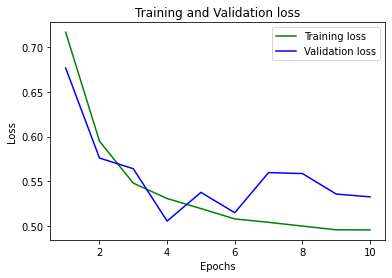

In [ ]:
import matplotlib.pyplot as plt

loss_train = train_history_step1.history['loss']
loss_val = train_history_step1.history['val_loss']
epochs = range(1,11)
plt.plot(epochs, loss_train, 'g', label='Training loss')
plt.plot(epochs, loss_val, 'b', label='Validation loss')
plt.title('Training and Validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [ ]:
print(train_history_step1.history.keys())

SyntaxError: ignored

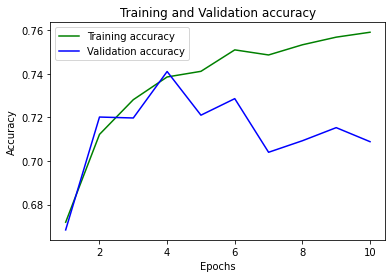

In [ ]:
loss_train = train_history_step1.history['accuracy']
loss_val = train_history_step1.history['val_accuracy']
epochs = range(1,11)
plt.plot(epochs, loss_train, 'g', label='Training accuracy')
plt.plot(epochs, loss_val, 'b', label='Validation accuracy')
plt.title('Training and Validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

In [ ]:
pd.DataFrame(train_history_step2.history).to_csv('history2.csv')

In [ ]:
model.save('/content/drive/My Drive/df/densenet.h5')

In [ ]:
model.summary()

NameError: ignored